In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.  
SCORE goes from -3.89 to 2.73.



Genes:17386  
Cell Lines:1086  
Primary Diseases:31  
Lineages:28  

## Extract data 

In [44]:
# Extract gene expression from CCLE_expression.csv
df = pd.read_csv('data/CCLE_expression.csv')
gene_expression = df.rename(columns={"Unnamed: 0":"DepMap"}).set_index("DepMap").dropna()

# Extract gene effect from CRISPR_gene_effect.csv
df = pd.read_csv('data/CRISPR_gene_effect.csv')
gene_effect = df.rename(columns={"DepMap_ID":"DepMap"}).set_index("DepMap").dropna()

## Clean datasets

In [108]:
gene_expression = gene_expression.sort_values(by = 'DepMap').reindex(sorted(gene_expression.columns), axis = 1)
gene_effect = gene_effect.sort_values(by = 'DepMap').reindex(sorted(gene_effect.columns), axis = 1)

In [109]:
def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

In [110]:
# Keep genes in common
cols1 = gene_expression.columns
cols2 = gene_effect.columns

cols = sorted(intersection(cols1, cols2))
gene_expression = gene_expression[cols]
gene_effect = gene_effect[cols]

In [111]:
# Keep cell lines in common
rows1 = list(gene_expression.index)
rows2 = list(gene_effect.index)

rows = intersection(rows1, rows2)
gene_expression = gene_expression.reindex(index = sorted(rows))
gene_effect = gene_effect.reindex(index = sorted(rows))

In [211]:
len(cols)

17283

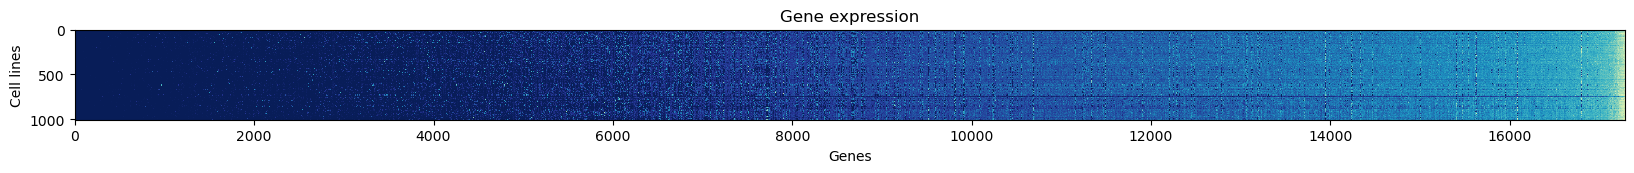

In [127]:
sorted_df = gene_expression.reindex(gene_expression.mean().sort_values().index, axis=1)
#sorted_df['Mean'] = df.mean(axis=0)
#sorted_df = sorted_df.sort_values(by='Mean', axis=0)
fig = plt.figure(figsize=(20,20))
plt.imshow(-sorted_df.to_numpy(), cmap="YlGnBu",interpolation='nearest')
plt.xlabel("Genes")
plt.ylabel("Cell lines")
plt.title("Gene expression")
plt.show()

In [204]:
gepxrflat = gene_expression.reindex(gene_expression.mean().sort_values().index, axis=1).to_numpy().flatten()
geffflat = gene_effect.reindex(gene_expression.mean().sort_values().index, axis=1).to_numpy().flatten()

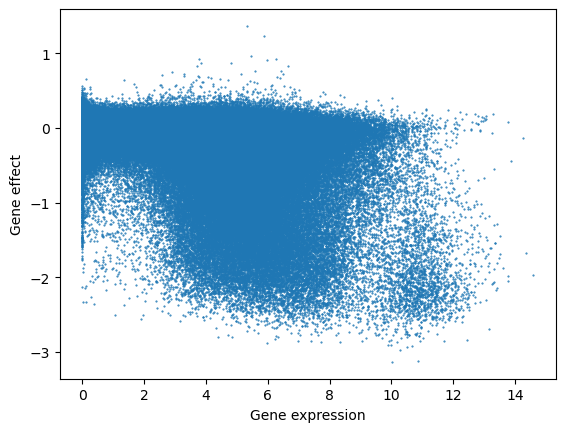

In [206]:
nb_pts = 500000
plt.scatter(gepxrflat[:nb_pts], geffflat[:nb_pts], marker='.', s=1)
plt.xlabel("Gene expression")
plt.ylabel("Gene effect")
plt.show()

# ML

## Define X,y

In [57]:
#loss = F.binary_cross_entropy_with_logits # numerically stable
loss_function = F.mse_loss

device="cpu"

In [52]:
nb_genes = 5_000
nb_cell_lines = 500

In [53]:
X = gene_expression.iloc[:nb_cell_lines,:nb_genes].to_numpy('float')
y = gene_effect.iloc[:nb_cell_lines,:nb_genes].to_numpy('float')

In [55]:
def set_split(X, y, proportion):
    index = np.arange(len(X))
    np.random.shuffle(index)
    sum_p = sum(proportion)
    proportion = [p / sum_p for p in proportion]
    prop=0
    N = len(index)
    X_splits = []
    y_splits = []
    for i in range(len(proportion)):
        start_index = round( N*prop )
        end_index = round( N*(prop+proportion[i]) )
        
        set_index = index[start_index: end_index]
        X_splits.append( X[set_index] )
        y_splits.append( y[set_index] )
        
        prop += proportion[i]

    return X_splits, y_splits

In [58]:
X_splits, y_splits = set_split(X, y, [0.7,0.2,0.1])
X_splits = [torch.tensor(x, device=device) for x in X_splits]
y_splits = [torch.tensor(y_, device=device) for y_ in y_splits]

X_train, X_val, X_test = X_splits
y_train, y_val, y_test = y_splits

In [65]:
print(X_train.size(), X_val.size(), X_test.size())

torch.Size([350, 5000]) torch.Size([100, 5000]) torch.Size([50, 5000])


In [66]:
def k_fold_split(X, y, K, prop_train_test, device):
    X_splits, y_splits = set_split(X, y, prop_train_test)
    X_train, X_test = X_splits
    y_train, y_test = y_splits
    X_folds, y_folds = set_split(X_train, y_train, [1/K] * K)
    
    X_folds = [torch.tensor(x, device=device) for x in X_folds]
    y_folds = [torch.tensor(y_, device=device) for y_ in y_folds]
    X_test = torch.tensor(X_test, device=device)
    y_test = torch.tensor(y_test, device=device)

    return X_folds, y_folds, X_test, y_test

# X_folds, y_folds, X_test, y_test = k_fold_split(X, y, 5, [0.9, 0.1], device)

## Define model

In [70]:
class Net(torch.nn.Module):
    def __init__(self, input_size, output_size=None):
        super(Net, self).__init__()
        if output_size is None:
            output_size = input_size
        
        self.layer = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.layer(x.float())   
        return x

In [71]:
model = Net(nb_genes).to(device)

## Train model

In [74]:
def run_one_epoch(train_flag, dataloader, model, optimizer, loss_function, device):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader:

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to device

        output = model(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        loss = loss_function( output.float(), y.float() )

        if train_flag:  # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        
    return np.mean(losses)

In [75]:
# TODO make wrapper function. 

def train_model(model, X_train, y_train, X_val, y_val, 
                optimizer, loss_function, device, 
                batch_size=5, epochs=20, patience=10, 
                verbose=True):
    """
    Train a model and record loss.
    """

    # Make new Dataset and DataLoader objects for both training and validation data.
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = data_utils.TensorDataset(X_val, y_val)
    val_dataloader = data_utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Run the training loop with early stopping. 
    train_losses = []
    val_losses = []
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'model_checkpoint.pt' # to save the best model fit to date
    for epoch in tqdm(range(epochs)):
        start_time = timeit.default_timer()
        train_loss = run_one_epoch(True, train_dataloader, model, optimizer, loss_function, device)
        val_loss = run_one_epoch(False, val_dataloader, model, optimizer, loss_function, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        if verbose:
            print("Epoch %i | took %.2fs | Train loss: %.4f | Val loss: %.4f | Patience left: %i" % 
              (epoch+1, elapsed, train_loss, val_loss, patience_counter ))

    # Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    return model, train_losses, val_losses


In [72]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [208]:
trained_model, train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, 
                                                      optimizer, loss_function, device,
                                                      epochs=40, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████| 40/40 [07:47<00:00, 11.70s/it]


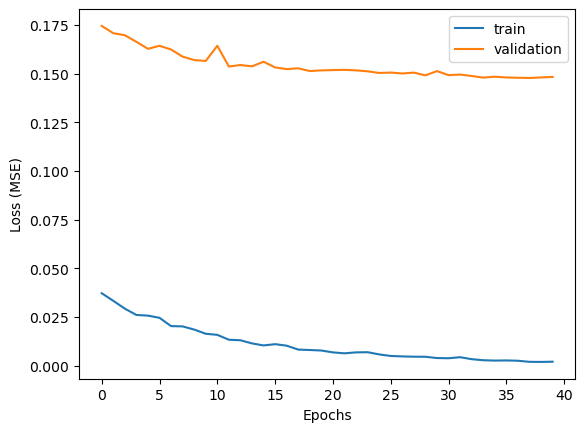

In [209]:
plt.plot(train_losses, label = "train")
plt.plot(val_losses, label = "validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()